In [9]:
# Experiment 3 KD with a smaller model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [5]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [6]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()    
    model.add(layers.Dense(8, activation='relu'))
        
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [7]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [8]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 2ms/step - mse: 1934.4973 - mae: 13.8703 - mape: 918.5745 - student_loss: 13.8358 - distillation_loss: 1926.0905 - val_mse: 25.6669 - val_mae: 3.0351 - val_mape: 186.7048 - val_student_loss: 5.0231
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 13.3597 - mae: 2.4226 - mape: 139.9979 - student_loss: 2.4200 - distillation_loss: 12.7143 - val_mse: 4.2975 - val_mae: 1.8191 - val_mape: 93.3131 - val_student_loss: 1.9092
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 4.1857 - mae: 1.7965 - mape: 90.8143 - student_loss: 1.7943 - distillation_loss: 3.7163 - val_mse: 3.9997 - val_mae: 1.7517 - val_mape: 88.7306 - val_student_loss: 1.8624
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 3.9761 - mae: 1.7382 - mape: 87.0165 - student_loss: 1.7379 - distillation_loss: 3.5156 - val_mse: 3.7869 - val_mae: 1.6906 - val_mape: 84.6350 - val_student_loss: 1.8015

443/443 [==============================] - 1s 2ms/step - mse: 0.7230 - mae: 0.6253 - mape: 39.0207 - student_loss: 0.6252 - distillation_loss: 0.3068 - val_mse: 0.5180 - val_mae: 0.5788 - val_mape: 43.4499 - val_student_loss: 0.7187
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4793 - mae: 0.5254 - mape: 34.2334 - student_loss: 0.5252 - distillation_loss: 0.0724 - val_mse: 0.4510 - val_mae: 0.5046 - val_mape: 32.1561 - val_student_loss: 0.5970
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4873 - mae: 0.5278 - mape: 34.0037 - student_loss: 0.5286 - distillation_loss: 0.0851 - val_mse: 0.4888 - val_mae: 0.5451 - val_mape: 38.2355 - val_student_loss: 0.6864
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4712 - mae: 0.5176 - mape: 33.2339 - student_loss: 0.5173 - distillation_loss: 0.0668 - val_mse: 0.4470 - val_mae: 0.5096 - val_mape: 33.4910 - val_student_loss: 0.6357
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5486 - mae: 0.5588 - mape: 36.8613 - student_loss: 0.5589 - distillation_loss: 0.1499 - val_mse: 0.5329 - val_mae: 0.5644 - val_mape: 36.4967 - val_student_loss: 0.6057
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4474 - mae: 0.5153 - mape: 35.4074 - student_loss: 0.5171 - distillation_loss: 0.0534 - val_mse: 0.4132 - val_mae: 0.5013 - val_mape: 34.8511 - val_student_loss: 0.6525
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4432 - mae: 0.5088 - mape: 34.3420 - student_loss: 0.5090 - distillation_loss: 0.0517 - val_mse: 0.4120 - val_mae: 0.4964 - val_mape: 33.8431 - val_student_loss: 0.6291
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4868 - mae: 0.5311 - mape: 35.3735 - student_loss: 0.5314 - distillation_loss: 0.0975 - val_mse: 0.4141 - val_mae: 0.5051 - val_mape: 35.5633 - val_student_loss: 0.6339
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4581 - mae: 0.5224 - mape: 36.3470 - student_loss: 0.5234 - distillation_loss: 0.0686 - val_mse: 0.4507 - val_mae: 0.5183 - val_mape: 34.3699 - val_student_loss: 0.6236
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 7.2073 - mse: 467.5547 - mae: 7.2073 - mape: 459.1322 - val_loss: 1.0588 - val_mse: 2.1483 - val_mae: 1.0588 - val_mape: 64.2774
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0144 - mse: 1.9411 - mae: 1.0144 - mape: 54.1778 - val_loss: 0.9504 - val_mse: 1.6651 - val_mae: 0.9504 - val_mape: 58.2979
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9366 - mse: 1.6467 - mae: 0.9366 - mape: 51.3905 - val_loss: 0.8718 - val_mse: 1.3532 - val_mae: 0.8718 - val_mape: 51.4032
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8893 - mse: 1.4335 - mae: 0.8893 - mape: 50.4233 - val_loss: 0.9104 - val_mse: 1.497

443/443 [==============================] - 1s 2ms/step - loss: 0.4990 - mse: 0.4538 - mae: 0.4990 - mape: 30.6820 - val_loss: 0.4886 - val_mse: 0.4218 - val_mae: 0.4886 - val_mape: 31.5100
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4970 - mse: 0.4502 - mae: 0.4970 - mape: 30.3335 - val_loss: 0.4843 - val_mse: 0.4235 - val_mae: 0.4843 - val_mape: 30.3900
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4979 - mse: 0.4529 - mae: 0.4979 - mape: 30.4247 - val_loss: 0.4862 - val_mse: 0.4265 - val_mae: 0.4862 - val_mape: 30.4482
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5009 - mse: 0.4561 - mae: 0.5009 - mape: 30.7968 - val_loss: 0.4946 - val_mse: 0.4526 - val_mae: 0.4946 - val_mape: 29.1879
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4987 - mse: 0.4537 - mae: 0.4987 - mape: 30.4064 - val_loss: 0.4885 - val_mse: 0.4196 - val_mae: 0.4885 - val_mape: 31.2210
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4898 - mse: 0.4392 - mae: 0.4898 - mape: 29.9261 - val_loss: 0.4908 - val_mse: 0.4541 - val_mae: 0.4908 - val_mape: 28.4854
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4893 - mse: 0.4415 - mae: 0.4893 - mape: 29.8299 - val_loss: 0.4805 - val_mse: 0.4152 - val_mae: 0.4805 - val_mape: 30.8019
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4895 - mse: 0.4408 - mae: 0.4895 - mape: 29.8663 - val_loss: 0.4757 - val_mse: 0.4060 - val_mae: 0.4757 - val_mape: 30.3035
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4900 - mse: 0.4387 - mae: 0.4900 - mape: 30.0052 - val_loss: 0.4754 - val_mse: 0.4223 - val_mae: 0.4754 - val_mape: 28.4914
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4879 - mse: 0.4359 - mae: 0.4879 - mape: 29.6684 - val_loss: 0.4761 - val_mse: 0.4207 - val_mae: 0.4761 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5819 - mae: 0.5899 - mape: 40.4911 - student_loss: 0.5922 - distillation_loss: 0.1635 - val_mse: 0.9388 - val_mae: 0.7440 - val_mape: 56.7432 - val_student_loss: 0.8970
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7739 - mae: 0.6471 - mape: 43.8551 - student_loss: 0.6458 - distillation_loss: 0.3588 - val_mse: 0.6217 - val_mae: 0.6014 - val_mape: 42.3314 - val_student_loss: 0.6245
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6279 - mae: 0.6031 - mape: 40.4034 - student_loss: 0.6026 - distillation_loss: 0.2056 - val_mse: 0.6251 - val_mae: 0.5878 - val_mape: 34.5062 - val_student_loss: 0.4190
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6676 - mae: 0.6163 - mape: 41.0495 - student_loss: 0.6168 - distillation_loss: 0.2466 - val_mse: 0.5425 - val_mae: 0.5553 - val_mape: 35.3402 - val_student_loss: 0.4458
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.6181 - mae: 0.5724 - mape: 37.8318 - student_loss: 0.5721 - distillation_loss: 0.1935 - val_mse: 0.6836 - val_mae: 0.6053 - val_mape: 32.4003 - val_student_loss: 0.3699
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6411 - mae: 0.5968 - mape: 38.9478 - student_loss: 0.5958 - distillation_loss: 0.2312 - val_mse: 0.5155 - val_mae: 0.5507 - val_mape: 36.0554 - val_student_loss: 0.4379
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5226 - mae: 0.5510 - mape: 36.0139 - student_loss: 0.5542 - distillation_loss: 0.1093 - val_mse: 1.0226 - val_mae: 0.7682 - val_mape: 56.5558 - val_student_loss: 0.7743
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6511 - mae: 0.6070 - mape: 39.4508 - student_loss: 0.6105 - distillation_loss: 0.2336 - val_mse: 0.5141 - val_mae: 0.5509 - val_mape: 36.2353 - val_student_loss: 0.4310
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5306 - mae: 0.5441 - mape: 35.0467 - student_loss: 0.5459 - distillation_loss: 0.1258 - val_mse: 0.7759 - val_mae: 0.6750 - val_mape: 48.2861 - val_student_loss: 0.5870
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5083 - mae: 0.5411 - mape: 35.0315 - student_loss: 0.5403 - distillation_loss: 0.1024 - val_mse: 0.5889 - val_mae: 0.5738 - val_mape: 37.7747 - val_student_loss: 0.3639
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5372 - mae: 0.5552 - mape: 35.7294 - student_loss: 0.5541 - distillation_loss: 0.1258 - val_mse: 0.4856 - val_mae: 0.5397 - val_mape: 35.7570 - val_student_loss: 0.4110
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5051 - mae: 0.5331 - mape: 34.1821 - student_loss: 0.5341 - distillation_loss: 0.0941 - val_mse: 0.4626 - val_mae: 0.5137 - val_mape: 31.1439 - val_student_loss: 0.3908
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6674 - mse: 0.8412 - mae: 0.6674 - mape: 41.2866 - val_loss: 0.5422 - val_mse: 0.5033 - val_mae: 0.5422 - val_mape: 34.1026
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6748 - mse: 0.8492 - mae: 0.6748 - mape: 42.0933 - val_loss: 0.7395 - val_mse: 0.9337 - val_mae: 0.7395 - val_mape: 53.0880
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7108 - mse: 0.9245 - mae: 0.7108 - mape: 44.8344 - val_loss: 0.9546 - val_mse: 1.7364 - val_mae: 0.9546 - val_mape: 69.0183
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6678 - mse: 0.8011 - mae: 0.6678 - mape: 41.4971 - val_loss: 0.5414 - val_mse: 0.5095 - val_mae: 0.5414 - val_mape: 33.6265
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6499 - mse: 0.7780 - mae: 0.6499 - mape: 40.2742 - val_loss: 1.2640 - val_mse: 3.0219 - val_mae: 1.2640 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.6012 - mse: 0.6696 - mae: 0.6012 - mape: 36.6519 - val_loss: 0.5250 - val_mse: 0.4905 - val_mae: 0.5250 - val_mape: 31.8372
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6149 - mse: 0.6815 - mae: 0.6149 - mape: 37.8473 - val_loss: 0.5298 - val_mse: 0.4966 - val_mae: 0.5298 - val_mape: 32.4275
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5852 - mse: 0.6329 - mae: 0.5852 - mape: 35.8048 - val_loss: 0.5224 - val_mse: 0.4980 - val_mae: 0.5224 - val_mape: 30.7614
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6152 - mse: 0.6885 - mae: 0.6152 - mape: 37.7597 - val_loss: 0.9311 - val_mse: 1.5063 - val_mae: 0.9311 - val_mape: 68.1688
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6626 - mse: 0.7958 - mae: 0.6626 - mape: 41.3405 - val_loss: 0.8217 - val_mse: 1.2012 - val_mae: 0.8217 - val_mape: 59.4676
Epo

443/443 [==============================] - 1s 2ms/step - mse: 2149.8347 - mae: 17.2079 - mape: 1146.6460 - student_loss: 17.1499 - distillation_loss: 2138.6640 - val_mse: 29.8771 - val_mae: 4.3988 - val_mape: 290.3551 - val_student_loss: 2.6011
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 22.0571 - mae: 3.4203 - mape: 216.7952 - student_loss: 3.4194 - distillation_loss: 21.2731 - val_mse: 10.1233 - val_mae: 2.5461 - val_mape: 161.4793 - val_student_loss: 1.3218
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 4.6496 - mae: 1.1851 - mape: 81.2154 - student_loss: 1.1824 - distillation_loss: 4.2262 - val_mse: 0.8427 - val_mae: 0.7409 - val_mape: 57.0917 - val_student_loss: 0.6270
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.8183 - mae: 0.7625 - mape: 53.8413 - student_loss: 0.7642 - distillation_loss: 1.3991 - val_mse: 0.8134 - val_mae: 0.6986 - val_mape: 46.1792 - val_student_loss: 0.5629
Epoch 5/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.8471 - mae: 0.6495 - mape: 42.2710 - student_loss: 0.6485 - distillation_loss: 0.4407 - val_mse: 1.3054 - val_mae: 0.8942 - val_mape: 67.8026 - val_student_loss: 0.6530
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0555 - mae: 0.6709 - mape: 43.5588 - student_loss: 0.6703 - distillation_loss: 0.6462 - val_mse: 0.6485 - val_mae: 0.6395 - val_mape: 46.9403 - val_student_loss: 0.5366
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 2.0204 - mae: 0.7542 - mape: 49.3409 - student_loss: 0.7527 - distillation_loss: 1.5842 - val_mse: 0.5390 - val_mae: 0.5807 - val_mape: 41.7433 - val_student_loss: 0.5099
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5840 - mae: 0.5646 - mape: 37.0969 - student_loss: 0.5642 - distillation_loss: 0.1813 - val_mse: 0.8142 - val_mae: 0.6648 - val_mape: 34.8683 - val_student_loss: 0.5181
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4984 - mae: 0.5332 - mape: 33.8007 - student_loss: 0.5356 - distillation_loss: 0.0949 - val_mse: 0.4811 - val_mae: 0.5321 - val_mape: 34.8008 - val_student_loss: 0.5437
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6032 - mae: 0.5799 - mape: 36.9677 - student_loss: 0.5791 - distillation_loss: 0.2011 - val_mse: 0.5129 - val_mae: 0.5225 - val_mape: 30.6273 - val_student_loss: 0.5249
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4992 - mae: 0.5350 - mape: 34.1796 - student_loss: 0.5347 - distillation_loss: 0.0965 - val_mse: 0.4771 - val_mae: 0.5295 - val_mape: 34.8813 - val_student_loss: 0.5353
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5672 - mae: 0.5686 - mape: 36.2726 - student_loss: 0.5683 - distillation_loss: 0.1664 - val_mse: 0.5434 - val_mae: 0.5939 - val_mape: 42.0518 - val_student_loss: 0.5434
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4982 - mae: 0.5357 - mape: 34.4723 - student_loss: 0.5360 - distillation_loss: 0.0991 - val_mse: 0.4814 - val_mae: 0.5380 - val_mape: 36.0983 - val_student_loss: 0.5309
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 2.0567 - mse: 55.1463 - mae: 2.0567 - mape: 132.1311 - val_loss: 0.7720 - val_mse: 0.9631 - val_mae: 0.7720 - val_mape: 52.5840
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7598 - mse: 0.9650 - mae: 0.7598 - mape: 49.4597 - val_loss: 0.8524 - val_mse: 1.0875 - val_mae: 0.8524 - val_mape: 67.8406
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7228 - mse: 0.8719 - mae: 0.7228 - mape: 47.0728 - val_loss: 0.6758 - val_mse: 0.7744 - val_mae: 0.6758 - val_mape: 42.0035
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6517 - mse: 0.7121 - mae: 0.6517 - mape: 42.8851 - val_loss: 0.6131 - val_mse: 0.6069

443/443 [==============================] - 1s 2ms/step - loss: 0.5121 - mse: 0.4773 - mae: 0.5121 - mape: 31.0005 - val_loss: 0.4934 - val_mse: 0.4612 - val_mae: 0.4934 - val_mape: 28.9870
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5087 - mse: 0.4709 - mae: 0.5087 - mape: 30.9836 - val_loss: 0.4871 - val_mse: 0.4259 - val_mae: 0.4871 - val_mape: 31.0060
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5007 - mse: 0.4539 - mae: 0.5007 - mape: 30.4794 - val_loss: 0.5002 - val_mse: 0.4393 - val_mae: 0.5002 - val_mape: 32.4119
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5107 - mse: 0.4714 - mae: 0.5107 - mape: 31.2100 - val_loss: 0.5444 - val_mse: 0.5011 - val_mae: 0.5444 - val_mape: 37.0635
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5081 - mse: 0.4674 - mae: 0.5081 - mape: 30.9907 - val_loss: 0.4835 - val_mse: 0.4292 - val_mae: 0.4835 - val_mape: 30.1784
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4967 - mse: 0.4467 - mae: 0.4967 - mape: 30.5203 - val_loss: 0.4887 - val_mse: 0.4516 - val_mae: 0.4887 - val_mape: 28.6447
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5004 - mse: 0.4530 - mae: 0.5004 - mape: 30.6139 - val_loss: 0.4846 - val_mse: 0.4177 - val_mae: 0.4846 - val_mape: 30.9754
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4987 - mse: 0.4498 - mae: 0.4987 - mape: 30.6367 - val_loss: 0.4807 - val_mse: 0.4196 - val_mae: 0.4807 - val_mape: 30.1631
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4959 - mse: 0.4460 - mae: 0.4959 - mape: 30.4360 - val_loss: 0.5138 - val_mse: 0.5017 - val_mae: 0.5138 - val_mape: 28.6965
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4977 - mse: 0.4474 - mae: 0.4977 - mape: 30.4671 - val_loss: 0.4789 - val_mse: 0.4284 - val_mae: 0.4789 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7091 - mae: 0.6235 - mape: 40.3240 - student_loss: 0.6252 - distillation_loss: 0.2758 - val_mse: 0.5667 - val_mae: 0.5668 - val_mape: 37.7417 - val_student_loss: 0.3156
Epoch 19/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5789 - mae: 0.5781 - mape: 37.5289 - student_loss: 0.5773 - distillation_loss: 0.1510 - val_mse: 0.7599 - val_mae: 0.6989 - val_mape: 52.1603 - val_student_loss: 0.5505
Epoch 20/100
443/443 [==============================] - 1s 3ms/step - mse: 0.6566 - mae: 0.6045 - mape: 39.2903 - student_loss: 0.6038 - distillation_loss: 0.2274 - val_mse: 0.6067 - val_mae: 0.6135 - val_mape: 44.0867 - val_student_loss: 0.4508
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 1.6398 - mae: 0.7075 - mape: 45.7918 - student_loss: 0.7064 - distillation_loss: 1.1975 - val_mse: 0.6102 - val_mae: 0.6194 - val_mape: 44.9888 - val_student_loss: 0.4698
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.6453 - mae: 0.6012 - mape: 38.7342 - student_loss: 0.6010 - distillation_loss: 0.2351 - val_mse: 0.5263 - val_mae: 0.5389 - val_mape: 34.2091 - val_student_loss: 0.3235
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6325 - mae: 0.5949 - mape: 38.3716 - student_loss: 0.5953 - distillation_loss: 0.2212 - val_mse: 0.5713 - val_mae: 0.5960 - val_mape: 41.8411 - val_student_loss: 0.4798
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7576 - mae: 0.6252 - mape: 40.2295 - student_loss: 0.6271 - distillation_loss: 0.3359 - val_mse: 3.8111 - val_mae: 1.4329 - val_mape: 83.7981 - val_student_loss: 0.8060
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 3.0129 - mae: 0.8559 - mape: 56.2143 - student_loss: 0.8535 - distillation_loss: 2.5654 - val_mse: 0.5582 - val_mae: 0.5903 - val_mape: 41.7441 - val_student_loss: 0.4912
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5365 - mae: 0.5519 - mape: 35.4180 - student_loss: 0.5514 - distillation_loss: 0.1230 - val_mse: 0.5740 - val_mae: 0.6041 - val_mape: 42.9617 - val_student_loss: 0.5403
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5406 - mae: 0.5593 - mape: 35.8501 - student_loss: 0.5582 - distillation_loss: 0.1316 - val_mse: 0.5021 - val_mae: 0.5316 - val_mape: 34.2871 - val_student_loss: 0.3545
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 1.4836 - mae: 0.7281 - mape: 47.1008 - student_loss: 0.7283 - distillation_loss: 1.0716 - val_mse: 0.5169 - val_mae: 0.5647 - val_mape: 39.3838 - val_student_loss: 0.4830
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4940 - mae: 0.5343 - mape: 34.3436 - student_loss: 0.5353 - distillation_loss: 0.0851 - val_mse: 0.5085 - val_mae: 0.5563 - val_mape: 38.4927 - val_student_loss: 0.4724
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9855 - mae: 0.7717 - mape: 50.6553 - val_loss: 0.7524 - val_mse: 0.9506 - val_mae: 0.7524 - val_mape: 51.4369
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9874 - mae: 0.7717 - mape: 50.5169 - val_loss: 0.7524 - val_mse: 0.9501 - val_mae: 0.7524 - val_mape: 51.4944
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9891 - mae: 0.7717 - mape: 50.3711 - val_loss: 0.7531 - val_mse: 0.9465 - val_mae: 0.7531 - val_mape: 51.9052
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9859 - mae: 0.7717 - mape: 50.6346 - val_loss: 0.7528 - val_mse: 0.9478 - val_mae: 0.7528 - val_mape: 51.7512
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9888 - mae: 0.7717 - mape: 50.4086 - val_loss: 0.7529 - val_mse: 0.9476 - val_mae: 0.7529 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9881 - mae: 0.7717 - mape: 50.4553 - val_loss: 0.7527 - val_mse: 0.9483 - val_mae: 0.7527 - val_mape: 51.6959
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7718 - mse: 0.9886 - mae: 0.7718 - mape: 50.4249 - val_loss: 0.7529 - val_mse: 0.9475 - val_mae: 0.7529 - val_mape: 51.7844
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9865 - mae: 0.7717 - mape: 50.5873 - val_loss: 0.7528 - val_mse: 0.9479 - val_mae: 0.7528 - val_mape: 51.7430
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9882 - mae: 0.7717 - mape: 50.4535 - val_loss: 0.7531 - val_mse: 0.9465 - val_mae: 0.7531 - val_mape: 51.9045
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 0.9860 - mae: 0.7717 - mape: 50.6271 - val_loss: 0.7525 - val_mse: 0.9500 - val_mae: 0.7525 - val_mape: 51.5078
Epo

443/443 [==============================] - 2s 3ms/step - mse: 641.2637 - mae: 8.9057 - mape: 604.1060 - student_loss: 8.8798 - distillation_loss: 639.2857 - val_mse: 9.5845 - val_mae: 2.5383 - val_mape: 176.0735 - val_student_loss: 2.0843
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 6.2455 - mae: 2.0430 - mape: 143.3025 - student_loss: 2.0421 - distillation_loss: 6.0077 - val_mse: 3.8849 - val_mae: 1.6263 - val_mape: 112.5652 - val_student_loss: 1.3179
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 3.4431 - mae: 1.5143 - mape: 103.5778 - student_loss: 1.5122 - distillation_loss: 3.0976 - val_mse: 2.7581 - val_mae: 1.3475 - val_mape: 89.3105 - val_student_loss: 1.2155
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 2.4721 - mae: 1.2713 - mape: 85.4259 - student_loss: 1.2716 - distillation_loss: 2.0961 - val_mse: 2.0590 - val_mae: 1.1605 - val_mape: 77.5705 - val_student_loss: 1.0812
Epoch 5/100
443/443 [==

443/443 [==============================] - 1s 2ms/step - mse: 0.5430 - mae: 0.5594 - mape: 36.4443 - student_loss: 0.5596 - distillation_loss: 0.1329 - val_mse: 0.5072 - val_mae: 0.5317 - val_mape: 31.2806 - val_student_loss: 0.5189
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5112 - mae: 0.5415 - mape: 35.1975 - student_loss: 0.5419 - distillation_loss: 0.0971 - val_mse: 0.4809 - val_mae: 0.5280 - val_mape: 33.7656 - val_student_loss: 0.4964
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5154 - mae: 0.5463 - mape: 35.3809 - student_loss: 0.5483 - distillation_loss: 0.1023 - val_mse: 0.4793 - val_mae: 0.5329 - val_mape: 34.9458 - val_student_loss: 0.4812
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5545 - mae: 0.5640 - mape: 36.5132 - student_loss: 0.5630 - distillation_loss: 0.1365 - val_mse: 0.4885 - val_mae: 0.5484 - val_mape: 37.1969 - val_student_loss: 0.4314
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5406 - mae: 0.5561 - mape: 36.3590 - student_loss: 0.5552 - distillation_loss: 0.1287 - val_mse: 0.4979 - val_mae: 0.5521 - val_mape: 37.7273 - val_student_loss: 0.4633
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5060 - mae: 0.5399 - mape: 35.1060 - student_loss: 0.5396 - distillation_loss: 0.0905 - val_mse: 0.4842 - val_mae: 0.5237 - val_mape: 32.1536 - val_student_loss: 0.5109
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4986 - mae: 0.5371 - mape: 34.7828 - student_loss: 0.5371 - distillation_loss: 0.0872 - val_mse: 0.4813 - val_mae: 0.5199 - val_mape: 31.9584 - val_student_loss: 0.5159
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5097 - mae: 0.5395 - mape: 34.7381 - student_loss: 0.5406 - distillation_loss: 0.1006 - val_mse: 2.4020 - val_mae: 1.2704 - val_mape: 95.5225 - val_student_loss: 0.7235
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4997 - mae: 0.5363 - mape: 34.8125 - student_loss: 0.5358 - distillation_loss: 0.0891 - val_mse: 0.4737 - val_mae: 0.5154 - val_mape: 31.5948 - val_student_loss: 0.5062
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 52.8051 - mse: 37632.2266 - mae: 52.8051 - mape: 3541.3650 - val_loss: 1.5202 - val_mse: 3.6787 - val_mae: 1.5202 - val_mape: 104.4649
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4705 - mse: 27.4215 - mae: 1.4705 - mape: 99.2495 - val_loss: 2.5289 - val_mse: 9.9182 - val_mae: 2.5289 - val_mape: 157.7918
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3238 - mse: 17.5825 - mae: 1.3238 - mape: 88.8988 - val_loss: 1.8896 - val_mse: 5.2963 - val_mae: 1.8896 - val_mape: 113.6573
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3466 - mse: 12.2891 - mae: 1.3466 - mape: 89.5683 - val_loss: 0.5564 - val

443/443 [==============================] - 1s 2ms/step - loss: 1.3321 - mse: 3.9433 - mae: 1.3321 - mape: 86.7783 - val_loss: 0.5467 - val_mse: 0.5598 - val_mae: 0.5467 - val_mape: 30.2124
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1020 - mse: 3.0114 - mae: 1.1020 - mape: 71.3138 - val_loss: 0.6039 - val_mse: 0.6759 - val_mae: 0.6039 - val_mape: 32.1549
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1574 - mse: 2.9169 - mae: 1.1574 - mape: 75.0036 - val_loss: 0.5635 - val_mse: 0.5401 - val_mae: 0.5635 - val_mape: 36.2300
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7745 - mse: 1.4486 - mae: 0.7745 - mape: 48.9773 - val_loss: 0.5312 - val_mse: 0.5000 - val_mae: 0.5312 - val_mape: 32.4816
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2948 - mse: 3.8346 - mae: 1.2948 - mape: 84.5632 - val_loss: 2.1175 - val_mse: 6.9061 - val_mae: 2.1175 - val_mape: 126.5256
Ep

443/443 [==============================] - 1s 2ms/step - loss: 0.8109 - mse: 1.3196 - mae: 0.8109 - mape: 51.9804 - val_loss: 0.5252 - val_mse: 0.5038 - val_mae: 0.5252 - val_mape: 30.8520
Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8185 - mse: 1.3926 - mae: 0.8185 - mape: 52.5484 - val_loss: 1.5780 - val_mse: 3.9293 - val_mae: 1.5780 - val_mape: 91.6017
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2247 - mse: 3.2726 - mae: 1.2247 - mape: 80.5861 - val_loss: 0.8808 - val_mse: 1.2467 - val_mae: 0.8808 - val_mape: 63.9508
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8807 - mse: 1.8361 - mae: 0.8807 - mape: 56.5209 - val_loss: 0.8376 - val_mse: 1.1151 - val_mae: 0.8376 - val_mape: 60.6363
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9777 - mse: 2.3220 - mae: 0.9777 - mape: 63.6812 - val_loss: 1.1986 - val_mse: 2.2611 - val_mae: 1.1986 - val_mape: 88.6812
Epo

443/443 [==============================] - 1s 2ms/step - mse: 0.5923 - mae: 0.5623 - mape: 37.1111 - student_loss: 0.5615 - distillation_loss: 0.1746 - val_mse: 0.5987 - val_mae: 0.5539 - val_mape: 37.5052 - val_student_loss: 0.7085
Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5999 - mae: 0.5637 - mape: 36.9493 - student_loss: 0.5643 - distillation_loss: 0.1837 - val_mse: 0.6109 - val_mae: 0.5326 - val_mape: 33.2573 - val_student_loss: 0.7155
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6701 - mae: 0.5958 - mape: 38.9263 - student_loss: 0.5964 - distillation_loss: 0.2508 - val_mse: 0.6425 - val_mae: 0.5487 - val_mape: 30.9094 - val_student_loss: 0.7653
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6291 - mae: 0.5782 - mape: 37.5324 - student_loss: 0.5803 - distillation_loss: 0.2155 - val_mse: 0.6459 - val_mae: 0.6237 - val_mape: 44.5853 - val_student_loss: 0.8055
Epoch 21/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5794 - mae: 0.5685 - mape: 36.4774 - student_loss: 0.5686 - distillation_loss: 0.1649 - val_mse: 0.5152 - val_mae: 0.5157 - val_mape: 32.6409 - val_student_loss: 0.7063
Epoch 51/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6873 - mae: 0.6246 - mape: 40.1310 - student_loss: 0.6242 - distillation_loss: 0.2879 - val_mse: 0.5125 - val_mae: 0.5270 - val_mape: 35.8322 - val_student_loss: 0.7106
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5710 - mae: 0.5706 - mape: 36.5535 - student_loss: 0.5709 - distillation_loss: 0.1571 - val_mse: 0.7098 - val_mae: 0.6089 - val_mape: 33.0808 - val_student_loss: 0.9126
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 3.4279 - mae: 0.8974 - mape: 57.9670 - student_loss: 0.8972 - distillation_loss: 2.9991 - val_mse: 0.8135 - val_mae: 0.6330 - val_mape: 44.9144 - val_student_loss: 0.8234
Epoch 54/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.6996 - mae: 0.5925 - mape: 37.9807 - student_loss: 0.5937 - distillation_loss: 0.3034 - val_mse: 1.4874 - val_mae: 1.0079 - val_mape: 75.9169 - val_student_loss: 1.1414
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7087 - mae: 0.6191 - mape: 39.7524 - student_loss: 0.6185 - distillation_loss: 0.2993 - val_mse: 0.6005 - val_mae: 0.6142 - val_mape: 44.0284 - val_student_loss: 0.8297
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5470 - mae: 0.5589 - mape: 35.9165 - student_loss: 0.5593 - distillation_loss: 0.1437 - val_mse: 0.5227 - val_mae: 0.5286 - val_mape: 34.6912 - val_student_loss: 0.6975
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6973 - mae: 0.6039 - mape: 38.8733 - student_loss: 0.6036 - distillation_loss: 0.2824 - val_mse: 0.5067 - val_mae: 0.5155 - val_mape: 33.2588 - val_student_loss: 0.6947
Epoch 87/100
443/443 [=======

Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9074 - mse: 1.7130 - mae: 0.9074 - mape: 58.2283 - val_loss: 0.9740 - val_mse: 1.4633 - val_mae: 0.9740 - val_mape: 71.5773
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8618 - mse: 1.5415 - mae: 0.8618 - mape: 54.6535 - val_loss: 0.5405 - val_mse: 0.5411 - val_mae: 0.5405 - val_mape: 33.0398
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7417 - mse: 1.0766 - mae: 0.7417 - mape: 46.8599 - val_loss: 0.5815 - val_mse: 0.6374 - val_mae: 0.5815 - val_mape: 33.3344
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9151 - mse: 1.6727 - mae: 0.9151 - mape: 59.1351 - val_loss: 0.8186 - val_mse: 1.1763 - val_mae: 0.8186 - val_mape: 43.2553
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8803 - mse: 1.5017 - mae: 0.8803 - mape: 56.0264 - val_loss: 0.5683 - val_mse: 0.5733 - val_mae: 0.5683 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.7283 - mse: 1.0633 - mae: 0.7283 - mape: 45.9637 - val_loss: 1.2520 - val_mse: 2.5145 - val_mae: 1.2520 - val_mape: 71.0146
Epoch 61/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7781 - mse: 1.2910 - mae: 0.7781 - mape: 49.4959 - val_loss: 0.8042 - val_mse: 1.0645 - val_mae: 0.8042 - val_mape: 57.7206
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8343 - mse: 1.4479 - mae: 0.8343 - mape: 53.6774 - val_loss: 0.6934 - val_mse: 0.9544 - val_mae: 0.6934 - val_mape: 49.1920
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7150 - mse: 1.1209 - mae: 0.7150 - mape: 44.9405 - val_loss: 0.9330 - val_mse: 1.5324 - val_mae: 0.9330 - val_mape: 66.7282
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7852 - mse: 1.2249 - mae: 0.7852 - mape: 50.5987 - val_loss: 0.8144 - val_mse: 1.5899 - val_mae: 0.8144 - val_mape: 45.2424
Epo

Fold 6
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - mse: 30516.9473 - mae: 123.1479 - mape: 8228.3369 - student_loss: 122.8674 - distillation_loss: 30401.4215 - val_mse: 5722.0698 - val_mae: 57.9931 - val_mape: 3770.0967 - val_student_loss: 74.1354
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 2770.9902 - mae: 38.8006 - mape: 2604.1367 - student_loss: 38.7141 - distillation_loss: 2757.5875 - val_mse: 1315.3879 - val_mae: 26.9678 - val_mape: 1762.8053 - val_student_loss: 34.6508
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 771.3313 - mae: 20.0739 - mape: 1360.7864 - student_loss: 20.0767 - distillation_loss: 768.4393 - val_mse: 457.9370 - val_mae: 15.3064 - val_mape: 1008.5894 - val_student_loss: 19.7187
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 292.6469 - mae: 11.7404 - mape: 805.2883 - student_loss: 11.7672 - distillation_loss: 292.8044 - val_mse: 191.0925 - val_mae: 9.4205

Epoch 34/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4564 - mae: 0.5100 - mape: 33.1858 - student_loss: 0.5094 - distillation_loss: 0.0628 - val_mse: 0.4713 - val_mae: 0.4994 - val_mape: 30.5914 - val_student_loss: 1.1819
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4545 - mae: 0.5121 - mape: 33.5979 - student_loss: 0.5122 - distillation_loss: 0.0634 - val_mse: 0.4645 - val_mae: 0.5011 - val_mape: 31.0242 - val_student_loss: 0.9870
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4634 - mae: 0.5167 - mape: 34.0270 - student_loss: 0.5168 - distillation_loss: 0.0677 - val_mse: 0.4714 - val_mae: 0.4961 - val_mape: 29.1693 - val_student_loss: 1.0721
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4524 - mae: 0.5101 - mape: 33.6107 - student_loss: 0.5098 - distillation_loss: 0.0585 - val_mse: 0.4572 - val_mae: 0.4983 - val_mape: 31.1419 - val_student_loss: 0.9220
Epoch 38/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.4387 - mae: 0.5053 - mape: 33.5344 - student_loss: 0.5050 - distillation_loss: 0.0568 - val_mse: 0.4607 - val_mae: 0.4986 - val_mape: 30.0506 - val_student_loss: 1.0027
Epoch 68/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4282 - mae: 0.4973 - mape: 32.8884 - student_loss: 0.4969 - distillation_loss: 0.0479 - val_mse: 0.4466 - val_mae: 0.4999 - val_mape: 31.8667 - val_student_loss: 0.8621
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4401 - mae: 0.5062 - mape: 33.5334 - student_loss: 0.5054 - distillation_loss: 0.0611 - val_mse: 0.4654 - val_mae: 0.5011 - val_mape: 30.0857 - val_student_loss: 0.9970
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4390 - mae: 0.5056 - mape: 33.5966 - student_loss: 0.5062 - distillation_loss: 0.0567 - val_mse: 0.4451 - val_mae: 0.4993 - val_mape: 31.9378 - val_student_loss: 0.8600
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4237 - mae: 0.4943 - mape: 32.6089 - student_loss: 0.4950 - distillation_loss: 0.0447 - val_mse: 0.4389 - val_mae: 0.4950 - val_mape: 31.5915 - val_student_loss: 0.8546
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 11.5609 - mse: 834.2888 - mae: 11.5609 - mape: 728.0943 - val_loss: 1.4916 - val_mse: 3.1166 - val_mae: 1.4916 - val_mape: 70.5054
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2928 - mse: 2.6075 - mae: 1.2928 - mape: 58.0993 - val_loss: 1.1199 - val_mse: 2.0628 - val_mae: 1.1199 - val_mape: 49.3946
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0115 - mse: 1.8040 - mae: 1.0115 - mape: 45.6600 - val_loss: 0.9062 - val_mse: 1.4743 - val_mae: 0.9062 - val_mape: 42.2001
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8682 - mse: 1.3663 - mae: 0.8682 - mape: 43.7057 - val_loss: 0.7978 - val_mse: 1.1

443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9912 - mae: 0.7731 - mape: 50.9566 - val_loss: 0.7402 - val_mse: 0.9255 - val_mae: 0.7402 - val_mape: 46.8970
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9928 - mae: 0.7731 - mape: 50.8311 - val_loss: 0.7401 - val_mse: 0.9248 - val_mae: 0.7401 - val_mape: 46.9431
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9928 - mae: 0.7731 - mape: 50.8339 - val_loss: 0.7402 - val_mse: 0.9257 - val_mae: 0.7402 - val_mape: 46.8830
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9936 - mae: 0.7731 - mape: 50.7584 - val_loss: 0.7401 - val_mse: 0.9242 - val_mae: 0.7401 - val_mape: 46.9821
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9933 - mae: 0.7731 - mape: 50.7819 - val_loss: 0.7401 - val_mse: 0.9233 - val_mae: 0.7401 - val_mape: 47.0488
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9935 - mae: 0.7731 - mape: 50.7728 - val_loss: 0.7402 - val_mse: 0.9257 - val_mae: 0.7402 - val_mape: 46.8866
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9941 - mae: 0.7731 - mape: 50.7254 - val_loss: 0.7401 - val_mse: 0.9234 - val_mae: 0.7401 - val_mape: 47.0416
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9921 - mae: 0.7731 - mape: 50.8712 - val_loss: 0.7402 - val_mse: 0.9256 - val_mae: 0.7402 - val_mape: 46.8879
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9937 - mae: 0.7731 - mape: 50.7741 - val_loss: 0.7402 - val_mse: 0.9253 - val_mae: 0.7402 - val_mape: 46.9093
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9932 - mae: 0.7731 - mape: 50.8025 - val_loss: 0.7402 - val_mse: 0.9263 - val_mae: 0.7402 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5231 - mae: 0.5495 - mape: 35.4072 - student_loss: 0.5493 - distillation_loss: 0.1087 - val_mse: 0.4716 - val_mae: 0.5386 - val_mape: 36.9030 - val_student_loss: 0.2368
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6793 - mae: 0.6128 - mape: 39.4158 - student_loss: 0.6114 - distillation_loss: 0.2630 - val_mse: 0.4691 - val_mae: 0.5326 - val_mape: 35.9808 - val_student_loss: 0.2621
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6607 - mae: 0.6061 - mape: 39.0697 - student_loss: 0.6073 - distillation_loss: 0.2492 - val_mse: 1.1005 - val_mae: 0.8653 - val_mape: 65.2739 - val_student_loss: 0.2706
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8654 - mae: 0.6480 - mape: 41.9713 - student_loss: 0.6471 - distillation_loss: 0.4560 - val_mse: 0.4647 - val_mae: 0.5271 - val_mape: 35.2734 - val_student_loss: 0.2494
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.6147 - mae: 0.5755 - mape: 37.0063 - student_loss: 0.5773 - distillation_loss: 0.2032 - val_mse: 0.8050 - val_mae: 0.7555 - val_mape: 57.9797 - val_student_loss: 0.2601
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5521 - mae: 0.5678 - mape: 36.9411 - student_loss: 0.5679 - distillation_loss: 0.1380 - val_mse: 0.4625 - val_mae: 0.5217 - val_mape: 34.6163 - val_student_loss: 0.2555
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5360 - mae: 0.5557 - mape: 36.1152 - student_loss: 0.5555 - distillation_loss: 0.1298 - val_mse: 0.5003 - val_mae: 0.5208 - val_mape: 30.8875 - val_student_loss: 0.3077
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5264 - mae: 0.5510 - mape: 35.8066 - student_loss: 0.5505 - distillation_loss: 0.1165 - val_mse: 0.5131 - val_mae: 0.5273 - val_mape: 30.7950 - val_student_loss: 0.3301
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9493 - mae: 0.7802 - mape: 56.0031 - student_loss: 0.7788 - distillation_loss: 0.5108 - val_mse: 0.9584 - val_mae: 0.7891 - val_mape: 56.2493 - val_student_loss: 0.7827
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9491 - mae: 0.7799 - mape: 55.9557 - student_loss: 0.7807 - distillation_loss: 0.5121 - val_mse: 0.9582 - val_mae: 0.7893 - val_mape: 56.3147 - val_student_loss: 0.7836
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9491 - mae: 0.7798 - mape: 55.9141 - student_loss: 0.7797 - distillation_loss: 0.5130 - val_mse: 0.9580 - val_mae: 0.7890 - val_mape: 56.2718 - val_student_loss: 0.7828
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9490 - mae: 0.7794 - mape: 55.8298 - student_loss: 0.7794 - distillation_loss: 0.5122 - val_mse: 0.9573 - val_mae: 0.7906 - val_mape: 56.7297 - val_student_loss: 0.7889
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7069 - mse: 0.9848 - mae: 0.7069 - mape: 44.1866 - val_loss: 1.0916 - val_mse: 1.8890 - val_mae: 1.0916 - val_mape: 59.5657
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6345 - mse: 0.7726 - mae: 0.6345 - mape: 39.1153 - val_loss: 1.0080 - val_mse: 1.5292 - val_mae: 1.0080 - val_mape: 76.8318
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6603 - mse: 0.8786 - mae: 0.6603 - mape: 41.0112 - val_loss: 0.5609 - val_mse: 0.5889 - val_mae: 0.5609 - val_mape: 30.4205
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6789 - mse: 0.9206 - mae: 0.6789 - mape: 42.7229 - val_loss: 0.5824 - val_mse: 0.6323 - val_mae: 0.5824 - val_mape: 30.9982
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6154 - mse: 0.7783 - mae: 0.6154 - mape: 38.1514 - val_loss: 0.6963 - val_mse: 0.8533 - val_mae: 0.6963 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.6201 - mse: 0.7485 - mae: 0.6201 - mape: 38.1028 - val_loss: 0.5144 - val_mse: 0.5040 - val_mae: 0.5144 - val_mape: 29.0960
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6107 - mse: 0.7433 - mae: 0.6107 - mape: 37.4531 - val_loss: 0.5102 - val_mse: 0.4619 - val_mae: 0.5102 - val_mape: 32.0886
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6130 - mse: 0.7275 - mae: 0.6130 - mape: 37.5223 - val_loss: 0.4991 - val_mse: 0.4604 - val_mae: 0.4991 - val_mape: 30.1475
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6019 - mse: 0.7556 - mae: 0.6019 - mape: 36.9582 - val_loss: 0.5106 - val_mse: 0.4503 - val_mae: 0.5106 - val_mape: 32.9744
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6632 - mse: 0.9024 - mae: 0.6632 - mape: 41.4953 - val_loss: 0.5172 - val_mse: 0.4553 - val_mae: 0.5172 - val_mape: 33.9924
Epo

443/443 [==============================] - 1s 2ms/step - mse: 3.8037 - mae: 1.1857 - mape: 75.0056 - student_loss: 1.1838 - distillation_loss: 3.2831 - val_mse: 4.2535 - val_mae: 0.7917 - val_mape: 57.6876 - val_student_loss: 0.7458
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 2.4002 - mae: 1.0004 - mape: 69.3290 - student_loss: 1.0000 - distillation_loss: 1.9639 - val_mse: 3.5410 - val_mae: 0.7736 - val_mape: 48.3796 - val_student_loss: 0.8350
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1454 - mae: 0.7951 - mape: 55.4873 - student_loss: 0.7965 - distillation_loss: 0.6938 - val_mse: 2.7984 - val_mae: 0.9334 - val_mape: 75.4368 - val_student_loss: 0.7217
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9509 - mae: 0.7364 - mape: 51.8037 - student_loss: 0.7370 - distillation_loss: 0.4992 - val_mse: 1.9107 - val_mae: 0.6826 - val_mape: 46.7670 - val_student_loss: 0.7800
Epoch 5/100
443/443 [===========

443/443 [==============================] - 1s 2ms/step - mse: 0.6368 - mae: 0.6000 - mape: 39.0528 - student_loss: 0.6010 - distillation_loss: 0.2147 - val_mse: 0.4921 - val_mae: 0.5236 - val_mape: 33.9110 - val_student_loss: 0.5972
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3604 - mae: 0.7449 - mape: 48.4997 - student_loss: 0.7454 - distillation_loss: 0.9355 - val_mse: 0.4934 - val_mae: 0.5162 - val_mape: 32.3373 - val_student_loss: 0.5752
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8097 - mae: 0.6635 - mape: 43.1250 - student_loss: 0.6654 - distillation_loss: 0.3843 - val_mse: 0.4873 - val_mae: 0.5201 - val_mape: 33.3701 - val_student_loss: 0.5924
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8527 - mae: 0.6332 - mape: 41.4468 - student_loss: 0.6330 - distillation_loss: 0.4204 - val_mse: 0.5053 - val_mae: 0.5499 - val_mape: 37.5253 - val_student_loss: 0.5505
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5332 - mae: 0.5548 - mape: 35.9708 - student_loss: 0.5545 - distillation_loss: 0.1099 - val_mse: 0.5092 - val_mae: 0.5138 - val_mape: 29.8938 - val_student_loss: 0.6489
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7475 - mae: 0.6161 - mape: 40.0009 - student_loss: 0.6170 - distillation_loss: 0.3222 - val_mse: 2.5004 - val_mae: 1.1382 - val_mape: 64.5253 - val_student_loss: 1.5187
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7944 - mae: 0.6494 - mape: 42.4818 - student_loss: 0.6504 - distillation_loss: 0.3693 - val_mse: 0.4794 - val_mae: 0.5049 - val_mape: 30.6834 - val_student_loss: 0.6110
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0688 - mae: 0.7376 - mape: 47.4224 - student_loss: 0.7376 - distillation_loss: 0.6385 - val_mse: 0.5004 - val_mae: 0.5198 - val_mape: 33.6858 - val_student_loss: 0.5778
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.8880 - mae: 0.6716 - mape: 43.3267 - student_loss: 0.6706 - distillation_loss: 0.4789 - val_mse: 0.5337 - val_mae: 0.5918 - val_mape: 42.3225 - val_student_loss: 0.5574
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 4.2407 - mse: 110.8654 - mae: 4.2407 - mape: 288.8844 - val_loss: 1.5208 - val_mse: 305.5433 - val_mae: 1.5208 - val_mape: 96.0736
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1300 - mse: 14.9704 - mae: 1.1300 - mape: 78.3008 - val_loss: 1.1501 - val_mse: 196.6892 - val_mae: 1.1501 - val_mape: 84.4702
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0048 - mse: 9.4560 - mae: 1.0048 - mape: 67.9807 - val_loss: 0.9552 - val_mse: 124.9127 - val_mae: 0.9552 - val_mape: 62.0342
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9391 - mse: 6.2578 - mae: 0.9391 - mape: 62.9338 - val_loss: 1.4656 - val_mse

443/443 [==============================] - 1s 2ms/step - loss: 0.7478 - mse: 1.2556 - mae: 0.7478 - mape: 47.9231 - val_loss: 0.5279 - val_mse: 5.5404 - val_mae: 0.5279 - val_mape: 30.8662
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6727 - mse: 1.1116 - mae: 0.6727 - mape: 42.5199 - val_loss: 0.7186 - val_mse: 5.8552 - val_mae: 0.7186 - val_mape: 38.5323
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6984 - mse: 1.1855 - mae: 0.6984 - mape: 44.0768 - val_loss: 0.6049 - val_mse: 5.7087 - val_mae: 0.6049 - val_mape: 42.1365
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7586 - mse: 1.3229 - mae: 0.7586 - mape: 48.5311 - val_loss: 0.5960 - val_mse: 5.8718 - val_mae: 0.5960 - val_mape: 32.1569
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7199 - mse: 1.1910 - mae: 0.7199 - mape: 45.8093 - val_loss: 0.9668 - val_mse: 5.6412 - val_mae: 0.9668 - val_mape: 72.4716
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6836 - mse: 1.1879 - mae: 0.6836 - mape: 43.3306 - val_loss: 0.7548 - val_mse: 5.2962 - val_mae: 0.7548 - val_mape: 55.6186
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7080 - mse: 1.2959 - mae: 0.7080 - mape: 44.7571 - val_loss: 0.6972 - val_mse: 5.6104 - val_mae: 0.6972 - val_mape: 48.8738
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7406 - mse: 1.4390 - mae: 0.7406 - mape: 47.0769 - val_loss: 0.7156 - val_mse: 5.6468 - val_mae: 0.7156 - val_mape: 51.4541
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6189 - mse: 1.1680 - mae: 0.6189 - mape: 38.5773 - val_loss: 1.3614 - val_mse: 8.5913 - val_mae: 1.3614 - val_mape: 101.3801
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6700 - mse: 1.1567 - mae: 0.6700 - mape: 42.3527 - val_loss: 0.5695 - val_mse: 6.5711 - val_mae: 0.5695 - val_map

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9444 - mae: 0.7778 - mape: 55.7964 - student_loss: 0.7777 - distillation_loss: 0.5131 - val_mse: 1.0152 - val_mae: 0.8084 - val_mape: 56.2561 - val_student_loss: 0.6561
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9443 - mae: 0.7789 - mape: 56.0817 - student_loss: 0.7786 - distillation_loss: 0.5128 - val_mse: 1.0163 - val_mae: 0.8071 - val_mape: 55.9065 - val_student_loss: 0.6607
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9445 - mae: 0.7786 - mape: 55.9993 - student_loss: 0.7773 - distillation_loss: 0.5131 - val_mse: 1.0166 - val_mae: 0.8063 - val_mape: 55.7061 - val_student_loss: 0.6635
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9446 - mae: 0.7784 - mape: 55.9286 - student_loss: 0.7786 - distillation_loss: 0.5125 - val_mse: 1.0152 - val_mae: 0.8079 - val_mape: 56.1317 - val_student_loss: 0.6575
Epoch 22/100
443

443/443 [==============================] - 1s 3ms/step - mse: 0.5498 - mae: 0.5645 - mape: 35.6045 - student_loss: 0.5658 - distillation_loss: 0.1411 - val_mse: 0.5950 - val_mae: 0.6001 - val_mape: 37.8308 - val_student_loss: 0.6069
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5387 - mae: 0.5599 - mape: 35.4591 - student_loss: 0.5601 - distillation_loss: 0.1341 - val_mse: 0.6250 - val_mae: 0.5694 - val_mape: 31.1922 - val_student_loss: 0.5363
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5312 - mae: 0.5564 - mape: 35.2997 - student_loss: 0.5564 - distillation_loss: 0.1258 - val_mse: 0.6244 - val_mae: 0.5662 - val_mape: 30.0738 - val_student_loss: 0.5392
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5213 - mae: 0.5509 - mape: 34.9822 - student_loss: 0.5501 - distillation_loss: 0.1216 - val_mse: 0.5537 - val_mae: 0.5451 - val_mape: 31.5262 - val_student_loss: 0.5448
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4113 - mae: 0.4846 - mape: 31.3350 - student_loss: 0.4841 - distillation_loss: 0.0399 - val_mse: 0.4328 - val_mae: 0.4859 - val_mape: 29.1677 - val_student_loss: 0.5050
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4320 - mae: 0.4977 - mape: 32.2778 - student_loss: 0.4963 - distillation_loss: 0.0581 - val_mse: 0.5517 - val_mae: 0.5360 - val_mape: 29.8978 - val_student_loss: 0.5495
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4283 - mae: 0.4952 - mape: 32.2092 - student_loss: 0.4958 - distillation_loss: 0.0551 - val_mse: 0.4302 - val_mae: 0.4953 - val_mape: 31.2161 - val_student_loss: 0.5017
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4111 - mae: 0.4835 - mape: 31.2603 - student_loss: 0.4843 - distillation_loss: 0.0407 - val_mse: 0.5527 - val_mae: 0.5394 - val_mape: 29.4825 - val_student_loss: 0.4871
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6788 - mse: 0.8815 - mae: 0.6788 - mape: 43.2186 - val_loss: 0.5264 - val_mse: 0.5369 - val_mae: 0.5264 - val_mape: 29.5233
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7171 - mse: 1.2378 - mae: 0.7171 - mape: 45.8756 - val_loss: 0.5993 - val_mse: 0.6769 - val_mae: 0.5993 - val_mape: 32.0757
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6984 - mse: 1.0485 - mae: 0.6984 - mape: 44.5434 - val_loss: 0.5193 - val_mse: 0.5072 - val_mae: 0.5193 - val_mape: 31.1066
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6321 - mse: 0.8249 - mae: 0.6321 - mape: 39.6904 - val_loss: 0.5750 - val_mse: 0.6089 - val_mae: 0.5750 - val_mape: 36.4880
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6868 - mse: 0.9245 - mae: 0.6868 - mape: 43.8990 - val_loss: 0.8572 - val_mse: 1.3091 - val_mae: 0.8572 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.6605 - mse: 0.8500 - mae: 0.6605 - mape: 41.9390 - val_loss: 0.5498 - val_mse: 0.5138 - val_mae: 0.5498 - val_mape: 36.0430
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7152 - mse: 1.0679 - mae: 0.7152 - mape: 45.8108 - val_loss: 0.5629 - val_mse: 0.5124 - val_mae: 0.5629 - val_mape: 37.6566
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6406 - mse: 0.7685 - mae: 0.6406 - mape: 40.6358 - val_loss: 0.5072 - val_mse: 0.4924 - val_mae: 0.5072 - val_mape: 28.7649
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6712 - mse: 0.8702 - mae: 0.6712 - mape: 42.6981 - val_loss: 1.0526 - val_mse: 1.9038 - val_mae: 1.0526 - val_mape: 76.6467
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6464 - mse: 0.7975 - mae: 0.6464 - mape: 40.9642 - val_loss: 0.6913 - val_mse: 0.8096 - val_mae: 0.6913 - val_mape: 48.6091
Epo

Validation mse with distillation 0.5506 +- 0.1315
Validation mse without disstillation 1.4284 +- 1.6484


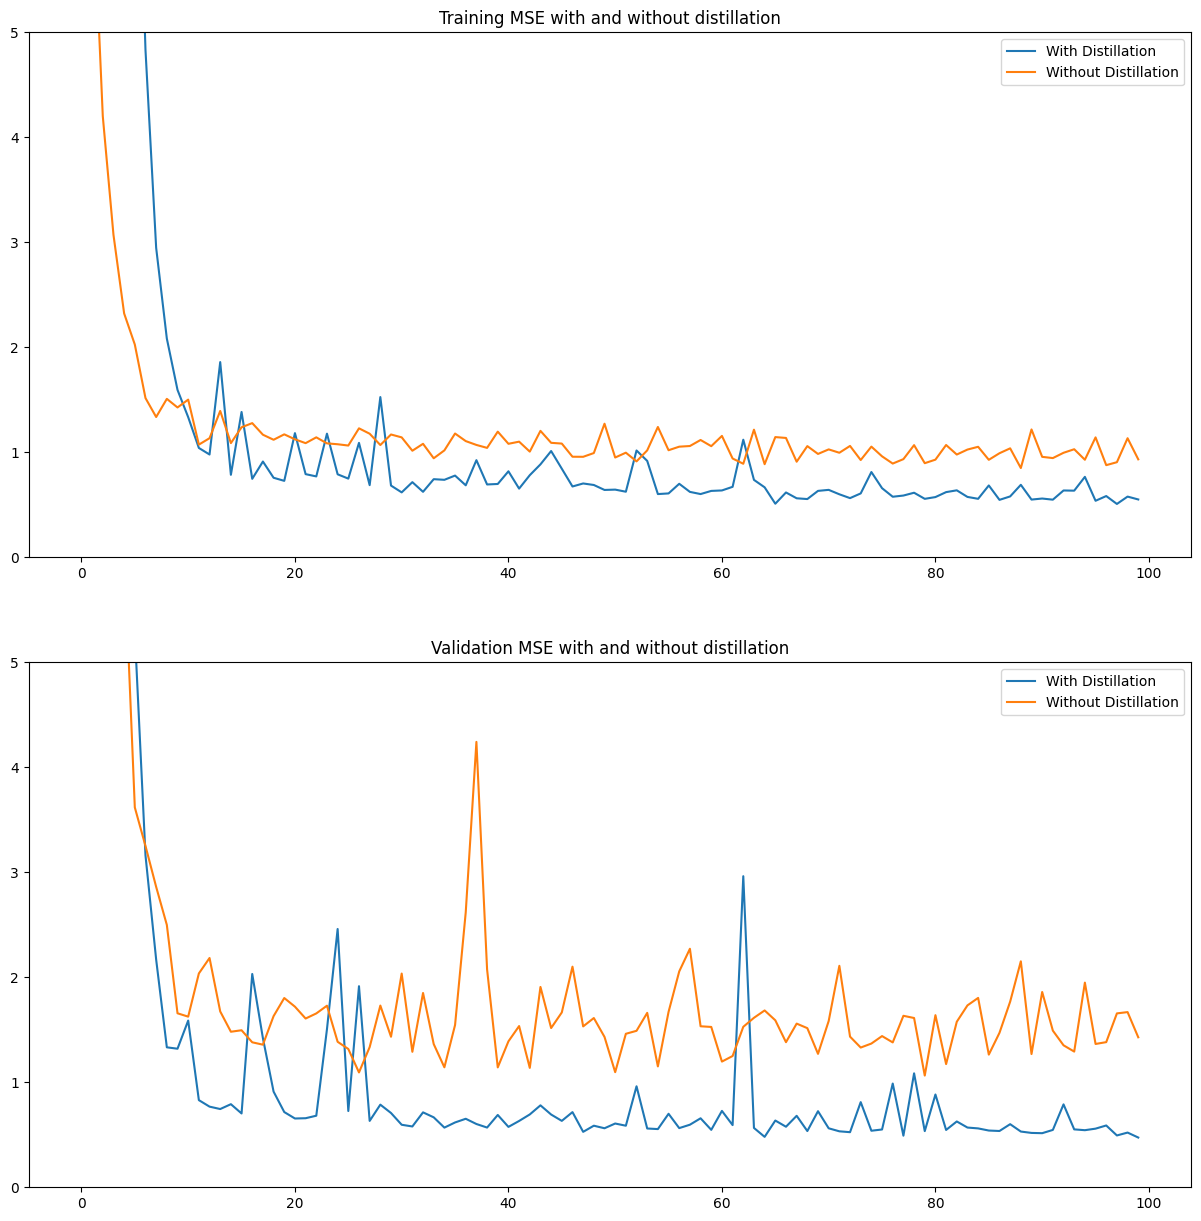

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.5439 +- 0.1428
Validation mse without disstillation 0.6897 +- 0.2324


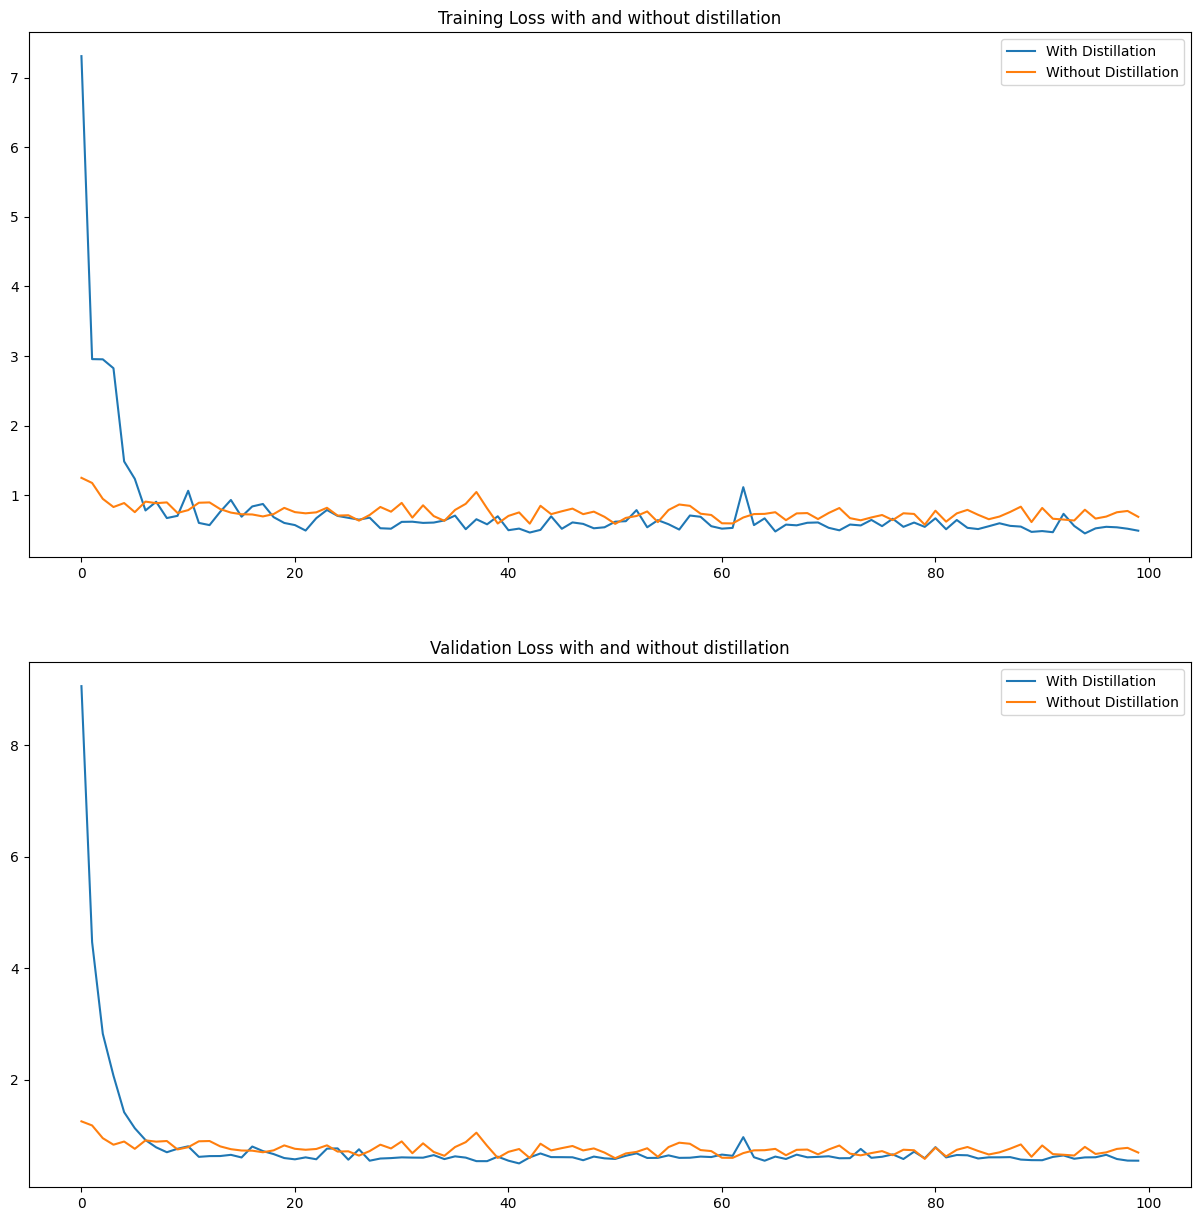

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [11]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 2s 3ms/step - mse: 83232.8125 - mae: 188.8188 - mape: 12615.5898 - student_loss: 188.3801 - distillation_loss: 82953.6820
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 2266.8000 - mae: 31.4288 - mape: 2117.2976 - student_loss: 31.3674 - distillation_loss: 2257.3729
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 29.6600 - mae: 2.9281 - mape: 196.8479 - student_loss: 2.9217 - distillation_loss: 28.7744
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 4.8072 - mae: 1.6628 - mape: 91.5515 - student_loss: 1.6623 - distillation_loss: 4.2497
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 4.5699 - mae: 1.6506 - mape: 89.3812 - student_loss: 1.6503 - distillation_loss: 4.0327
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 4.3862 - mae: 1.6054 - mape: 86.6216 - student_loss: 1.6089 - distillation_loss: 3.8545


492/492 [==============================] - 1s 2ms/step - mse: 0.9516 - mae: 0.7821 - mape: 56.1479 - student_loss: 0.7819 - distillation_loss: 0.5132
Epoch 52/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9517 - mae: 0.7817 - mape: 56.0430 - student_loss: 0.7830 - distillation_loss: 0.5151
Epoch 53/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9515 - mae: 0.7819 - mape: 56.1029 - student_loss: 0.7826 - distillation_loss: 0.5149
Epoch 54/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9518 - mae: 0.7814 - mape: 55.9788 - student_loss: 0.7824 - distillation_loss: 0.5127
Epoch 55/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9516 - mae: 0.7822 - mape: 56.1737 - student_loss: 0.7809 - distillation_loss: 0.5128
Epoch 56/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9518 - mae: 0.7809 - mape: 55.8469 - student_loss: 0.7813 - distillation_loss: 0.5143
Epoch 57/100
492/492 [=============

492/492 [==============================] - 1s 2ms/step - loss: 6.1304 - mse: 689.3389 - mae: 6.1304 - mape: 402.9707
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - loss: 1.0393 - mse: 12.2887 - mae: 1.0393 - mape: 70.5570
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 1.1123 - mse: 8.0318 - mae: 1.1123 - mape: 74.3104
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 1.0201 - mse: 5.2923 - mae: 1.0201 - mape: 67.0789
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 0.9560 - mse: 3.1673 - mae: 0.9560 - mape: 62.1875
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 0.8445 - mse: 2.0669 - mae: 0.8445 - mape: 54.0315
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 0.9066 - mse: 1.8744 - mae: 0.9066 - mape: 58.2355
Epoch 8/100
492/492 [==============================] - 1s 2ms/step - loss: 0.9524 - mse: 2.1216 - mae: 0.9524 - mape: 61.4388


492/492 [==============================] - 1s 2ms/step - loss: 0.8019 - mse: 1.3736 - mae: 0.8019 - mape: 51.4588
Epoch 66/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6670 - mse: 0.9061 - mae: 0.6670 - mape: 41.7848
Epoch 67/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7600 - mse: 1.1692 - mae: 0.7600 - mape: 48.6232
Epoch 68/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7713 - mse: 1.1844 - mae: 0.7713 - mape: 49.4369
Epoch 69/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6930 - mse: 1.0435 - mae: 0.6930 - mape: 43.5105
Epoch 70/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7797 - mse: 1.1874 - mae: 0.7797 - mape: 50.1783
Epoch 71/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7890 - mse: 1.2561 - mae: 0.7890 - mape: 50.4473
Epoch 72/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6680 - mse: 1.1037 - mae: 0.6680 - mape: 42.12

In [12]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 1.330365777015686, 'mae': 0.8783898949623108, 'mape': 56.79214859008789, 'student_loss': 0.7915266752243042}
Test mse without disstillation {'loss': 0.7161791920661926, 'mse': 0.8817212581634521, 'mae': 0.7161791920661926, 'mape': 48.218162536621094}


In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
